# (3.3) Case Study Notebook
This notebook recreates the results for the case study (Hurricane Larry) in Saranya Ganesh et al. (2025). The notebook creates code blocks to generate the ML predictions of Hurricane Larry 24-hour intensification rates, SHAP decomposition of the difference between SHIPS+ and SHIPS models, and the Larry-specific SHAP feature importance. Similar to the other Part 3 notebooks, all results related to the MLPs in the notebook are derived then stored in small data files for reproduction of the main paper figures in all types of computing environments. Additionally, the scripts used to produce MLP results are attached at the end of the notebook.

In [14]:
# Import required packages
from tqdm.auto import tqdm 
from tqdm import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
import os
from sklearn.metrics import r2_score
# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1
from scipy.stats import pearsonr
import torch.nn as nn
import torch
import torch.functional as F
import joblib
from util.results import part3

## Useful functions and read data

In [15]:
def calc_pcc_to_plot_figure5(seeds,target,config_set,folds,exp,scoretype):
    score_nocausal = []
    for seed in tqdm(seeds):
        nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp=exp).run_score_noFS()
        score_nocausal.append(nocausal_results)
        del nocausal_results
        gc.collect()

    pcc_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2_from_pcc'] for i in range(len(score_nocausal))]
    pcc_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2_from_pcc'] for i in range(len(score_nocausal))]
    pcc_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2_from_pcc'] for i in range(len(score_nocausal))]

    r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
    r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
    r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]

    stormdict_noFS = [get_stormdict_noFS(score_nocausal,foldz, scoretype)[0] for foldz in folds]
    timeseries_noFS = [get_stormdict_noFS(score_nocausal,foldz, scoretype)[1] for foldz in folds]
    return stormdict_noFS,timeseries_noFS,score_nocausal

In [ ]:
# Read configuration file, seeds, and target
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==20:
    target='DELV120'
if int(config_set['target_lag'])==16:
    target='DELV96'
if int(config_set['target_lag'])==12:
    target='DELV72'
if int(config_set['target_lag'])==8:
    target='DELV48'
if int(config_set['target_lag'])==4:
    target='DELV24'
seeds = np.arange(0,7,1)#np.arange(100,131,1)
target='DELV24'
# Read a dataset to obtain the indices of each test storm
store_nofs = miss.read_pickle('./results/4/shipsnew/results_fold_6.pkl')
Xnorml = store_nofs['dataframes'] #Get the stored pandas dataframes
causal_range_test = part3.get_range(Xnorml,4,target,'test') #find the indices for test storms

/Users/fredericktam/sciwork/2025_CausalSHIPS/util/results/part3.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  n = len(Xnorml[TYPE][key].dropna()[target][lagindx:])


In [ ]:
# get the processed time series to obtain MLP (pre-calculated) and MLR predictions for SHIPS (old) and SHIPS+ (plus)
stormdict_noFS_old,timeseries_noFS_old,score_nocausal_old = calc_pcc_to_plot_figure5(seeds,target,config_set,[0,1,2,3,4,5,6],'shipsold','R2')
stormdict_noFS_plus,timeseries_noFS_plus,score_nocausal_plus = calc_pcc_to_plot_figure5(seeds,target,config_set,[0,1,2,3,4,5,6],'shipsnew','R2')

  0%|          | 0/7 [00:00<?, ?it/s]/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:132: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:134: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yvalid = np.concatenate([np.asarray(Xnorml['valid'][ke

In [26]:
# Load the MLP predictions for SHIPS and SHIPS+ datasets
ships_plus_mlp = joblib.load('./MLP_data_for_part3/part3_case_ships_plus_mlp.joblib')
ships_old_mlp = joblib.load('./MLP_data_for_part3/part3_case_ships_old_mlp.joblib')

### Plot the entire test set (in long time series format) to have an overview of the test skills for different models

In [27]:
# Set global font size
plt.rcParams.update({'font.size': 15})
# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'
izlc=3

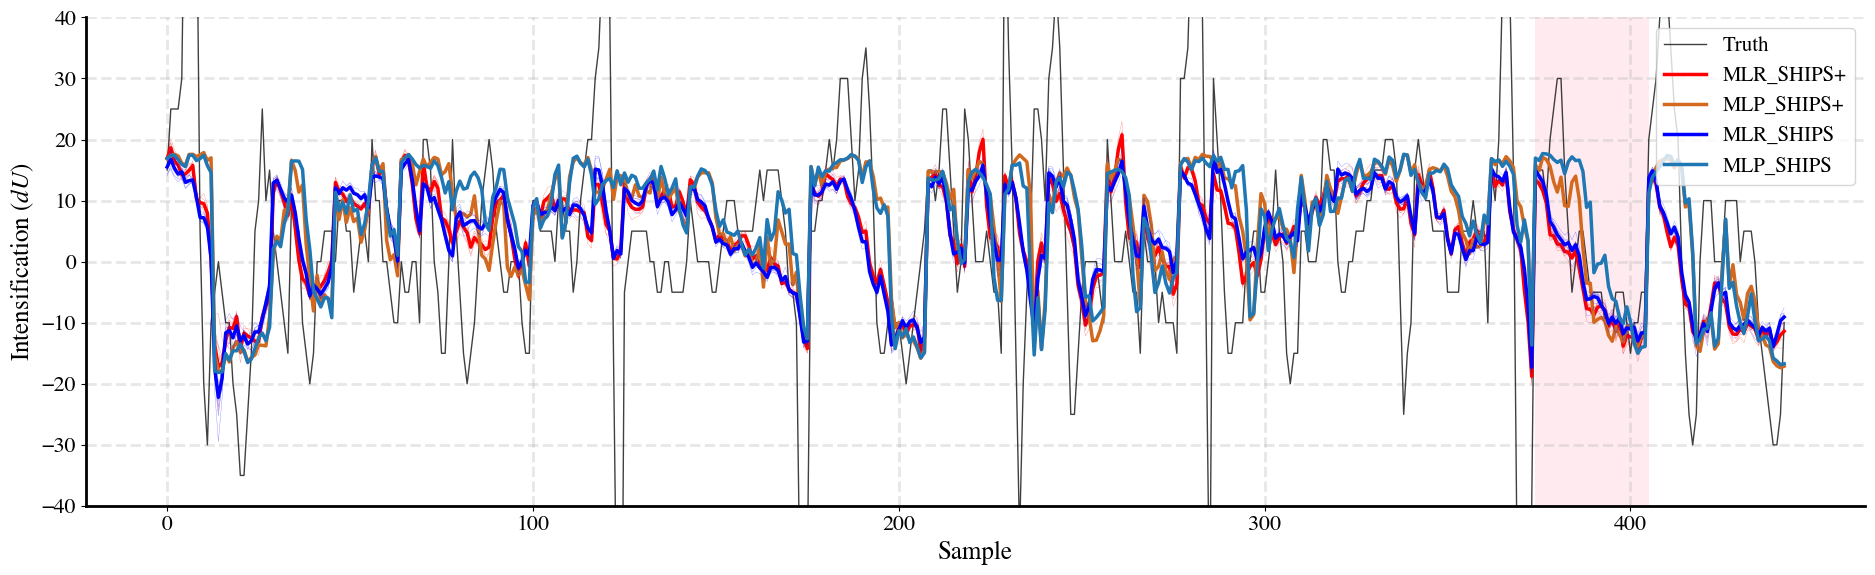

In [28]:
fig, axs = plt.subplots(1, figsize=(19,6))
plt.plot(score_nocausal_old[izlc]['y']['test'],lw=1,color='k',alpha=0.75,label='Truth')
#plt.plot(score_nocausal_old[izlc]['regr'].predict(score_nocausal_old[izlc]['X']['test']),lw=2,label='MLR')
ships_plus_mlr = []
for izlc in range(7):
    ships_plus_mlr.append(score_nocausal_plus[izlc]['regr'].predict(score_nocausal_plus[izlc]['X']['test']))
    plt.plot(score_nocausal_plus[izlc]['regr'].predict(score_nocausal_plus[izlc]['X']['test']),lw=0.25,alpha=0.5,color='r')
plt.plot(np.mean(np.asarray(ships_plus_mlr),axis=0),lw=2.5,color='r',label='MLR_SHIPS+')
plt.plot(np.mean(np.asarray(ships_plus_mlp),axis=0),lw=2.5,color='chocolate',label='MLP_SHIPS+')

ships_old_mlr = []
for izlc in range(7):
    ships_old_mlr.append(score_nocausal_old[izlc]['regr'].predict(score_nocausal_old[izlc]['X']['test']))
    plt.plot(score_nocausal_old[izlc]['regr'].predict(score_nocausal_old[izlc]['X']['test']),lw=0.25,alpha=0.5,color='b')
plt.plot(np.mean(np.asarray(ships_old_mlr),axis=0),lw=2.5,color='b',label='MLR_SHIPS')
plt.plot(np.mean(np.asarray(ships_old_mlp),axis=0),lw=2.5,color='tab:blue',label='MLP_SHIPS')

import matplotlib.patches as patches

# Add pink transparent rectangle
rect = patches.Rectangle((374, -40),   # (x,y) of bottom left corner
                         405 - 374,  # width
                         80,        # height
                         linewidth=0,
                         edgecolor=None,
                         facecolor='pink',
                         alpha=0.3)

axs.add_patch(rect)

plt.ylim(-40,40)
plt.grid(lw=2,alpha=0.3,ls='--')
plt.legend(loc=1)
#plt.title('Larry (2021)')
plt.xlabel('Sample',size=18)
plt.ylabel('Intensification ($dU$)',size=18)
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(2)
axs.spines['top'].set_linewidth(0)
axs.spines['right'].set_linewidth(0)
# Increase tick label size
axs.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('./teest_with_MLP.png',dpi=500)
plt.legend()

## Hone in on Hurricane Larry

In [29]:
case = '2021_LARRY'

### Prediction Time series 

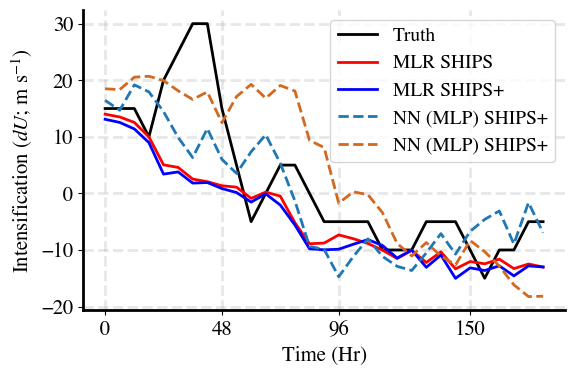

In [ ]:
fig, axs = plt.subplots(1, figsize=(6,4))
isais_loc = list(timeseries_noFS_old[0]['name']).index(case)
ytruth_isais = timeseries_noFS_old[0]['ytruth'][isais_loc]
plt.plot(np.arange(len(ytruth_isais))*6,ytruth_isais,label='Truth',lw=2,color='k')
ypreds = []
for i in range(7):
    isais_loc = list(timeseries_noFS_old[i]['name']).index(case)
    ypred_isais = timeseries_noFS_old[i]['ypred'][isais_loc]
    ypreds.append(ypred_isais)
    plt.plot(np.arange(len(ytruth_isais))*6,ypred_isais,color='r',lw=0.2,alpha=0)
plt.plot(np.arange(len(ytruth_isais))*6,(ypreds[3]),lw=2,color='r',label='MLR SHIPS')

ypreds_plus = []
for i in range(7):
    isais_loc = list(timeseries_noFS_plus[i]['name']).index(case)
    ypred_isais = timeseries_noFS_plus[i]['ypred'][isais_loc]
    ypreds_plus.append(ypred_isais)
    plt.plot(np.arange(len(ytruth_isais))*6,ypred_isais,color='b',lw=0.2,alpha=0)
plt.plot(np.arange(len(ytruth_isais))*6,(ypreds_plus[3]),lw=2,color='b',label='MLR SHIPS+')

plt.plot(np.arange(len(ytruth_isais))*6,np.asarray(ships_plus_mlp)[3][374:405],lw=2,color='tab:blue',label='NN (MLP) SHIPS+',ls='--')
plt.plot(np.arange(len(ytruth_isais))*6,np.asarray(ships_old_mlp)[3][374:405],lw=2,color='chocolate',label='NN (MLP) SHIPS+',ls='--')

plt.grid(lw=2,alpha=0.3,ls='--')
plt.legend(loc=1,fontsize=14)
#plt.title('Larry (2021)')
plt.xlabel('Time (Hr)')
plt.xticks([0,48,96,150])
plt.ylabel('Intensification ($dU$; m s$^{-1}$)')
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(2)
axs.spines['top'].set_linewidth(0)
axs.spines['right'].set_linewidth(0)
plt.tight_layout()
plt.savefig('./larry_with_MLP.png',dpi=500)
plt.show()

### SHAP

In [36]:
import shap

Read SHAP values for the SHIPS and SHIPS+ model

In [37]:
def get_header(LT,exp='plus'):
    with open(f'./MLP_data_for_part3/shap/shap_results_old/{exp}_shap_values_{LT}.pkl','rb') as f:
        obj = pickle.load(f)
    return obj['headers'][1:]

# Read SHIPS and SHIPS+ SHAP values for 24-hr prediction MLPs
LT=4
with open(f'./MLP_data_for_part3/shap/shap_results/plus_shap_values_{LT}_larry.pkl','rb') as f:
    plus_shap_dict = pickle.load(f)
with open(f'./MLP_data_for_part3/shap/shap_results/ships_shap_values_{LT}_larry.pkl','rb') as f:
    ships_shap_dict = pickle.load(f)
# Get the header names for the SHAP arrays for plotting purposes
header_plus = get_header(4,'plus')
header_ships = get_header(4,'ships')
# Get the SHAP value arrays for SHIPS and SHIPS+
plus_larry = plus_shap_dict['explanation'].values[:,:,0]
ships_larry = ships_shap_dict['explanation'].values[:,:,0]

#### Explain the origin of the difference between SHIPS and SHIPS+ prediction with SHAP

In [38]:
# Explaining the difference in prediction for Larry (2021): The contributions for variables common to both SHIPS and SHIPS+ = difference in SHAP values between
# SHIPS SHAP and SHIPS+ SHAP
diff_shap = []
for ind, obj in enumerate(header_ships):
    orig_index = header_ships.index(obj)
    plus_index = header_plus.index(obj)
    diff_shap.append(ships_larry[:,orig_index]-plus_larry[:,plus_index])

# Explaining the difference in prediction for Larry (2021): The contributions for new SHIPS+ variables = negative of the SHIPS+ SHAP values
resiz_shap = []
for ind, obj in enumerate(['R001','R000','SHL0','SHL1','PVOR','SHMD']):
    plus_index = header_plus.index(obj)
    print(plus_index)
    resiz_shap.append(plus_larry[:,plus_index])

# Explaining the difference in prediction for Larry (2021): Contribution from common variables that are not "latitude" or "potential intensity"
existing_shap_not_top = np.asarray([obj for ind,obj in enumerate(diff_shap) if ind not in [header_ships.index('LAT'),header_ships.index('POT')]])
# Explaining the difference in prediction for Larry (2021): Contribution from new variables that are not in the top2 in terms of feature importance
plus_shap_not_top = np.asarray([-obj for ind,obj in enumerate(resiz_shap) if ind not in [0,4]])
# Explaining the difference in prediction for Larry (2021): Contribution from "non-crucial" variables
var_not_top = np.concatenate([existing_shap_not_top,plus_shap_not_top])

20
21
25
24
23
22


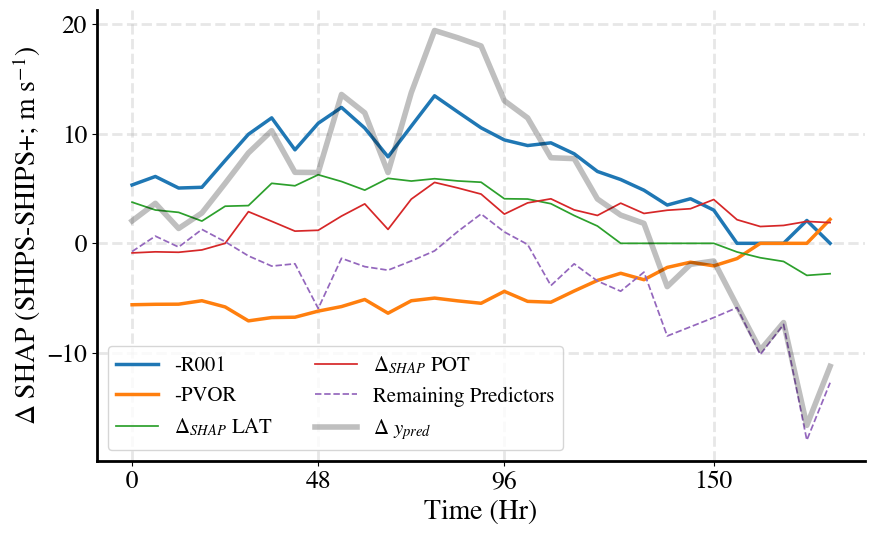

In [40]:
fig, axs = plt.subplots(1, figsize=(9,5.6))
izlc=3
# Set global font size
plt.rcParams.update({'font.size': 15})
# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

plt.plot(np.arange(len(ytruth_isais))*6,np.asarray([-sum([plus_larry[zzz,header_plus.index(obj)] for obj in ['R001']]) for zzz in range(31)]),lw=2.5,label='-R001')
plt.plot(np.arange(len(ytruth_isais))*6,np.asarray([-sum([plus_larry[zzz,header_plus.index(obj)] for obj in ['PVOR']]) for zzz in range(31)]),lw=2.5,label='-PVOR')
plt.plot(np.arange(len(ytruth_isais))*6,np.asarray(diff_shap)[header_ships.index('LAT')],lw=1.25,label='$\Delta_{SHAP}$ LAT')
plt.plot(np.arange(len(ytruth_isais))*6,np.asarray(diff_shap)[header_ships.index('POT')],lw=1.25,label='$\Delta_{SHAP}$ POT')
plt.plot(np.arange(len(ytruth_isais))*6,np.sum(var_not_top,axis=0),lw=1.25,ls='--',label='Remaining Predictors')
#plt.plot(np.sum(np.asarray(diff_shap),axis=0),lw=2,label='Sum(SHIPS)')
plt.plot(np.arange(len(ytruth_isais))*6,np.asarray(ships_old_mlp)[3][374:405]-np.asarray(ships_plus_mlp)[3][374:405],lw=4,alpha=0.25,label='$\Delta$ $y_{pred}$',c='k') 
plt.grid(lw=2,alpha=0.3,ls='--')
plt.legend(loc=3,ncol=2)
#plt.title('Larry (2021)')
plt.xlabel('Time (Hr)',fontsize=20)
plt.xticks([0,48,96,150])
plt.ylabel('$\Delta$ SHAP (SHIPS-SHIPS+; m s$^{-1}$)',fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=18.5)
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(2)
axs.spines['top'].set_linewidth(0)
axs.spines['right'].set_linewidth(0)
plt.tight_layout()
plt.savefig('./figures/case_study_ts.png',dpi=600)
plt.show()

#### What predictors contribute the most to the improvement of SHIPS+ models compared with SHIPS models?

In [41]:
# 23 Existing SHAP predictors (mean absolute value)
abs_shap_larry = pd.DataFrame({'values':np.abs(np.mean(np.asarray(diff_shap),axis=1)),'varname':header_ships})
# New Causal Predictors ['R001','R000','SHL0','SHL1','PVOR','SHMD']) (mean absolute value)
abs_plus_larry = pd.DataFrame({'values':np.abs(np.mean(np.asarray(resiz_shap),axis=1)),'varname':['R001','R000','SHL0','SHL1','PVOR','SHMD']})
# Combine the contributions from individual predictors into a Pandas Dataframe
shipsplus_abs_shap_larry = pd.concat([abs_shap_larry,abs_plus_larry])
# Sort the dataframe
shipsplus_abs_shap_larry_sorted = shipsplus_abs_shap_larry.set_index('varname').sort_values(by='values',ascending=False)

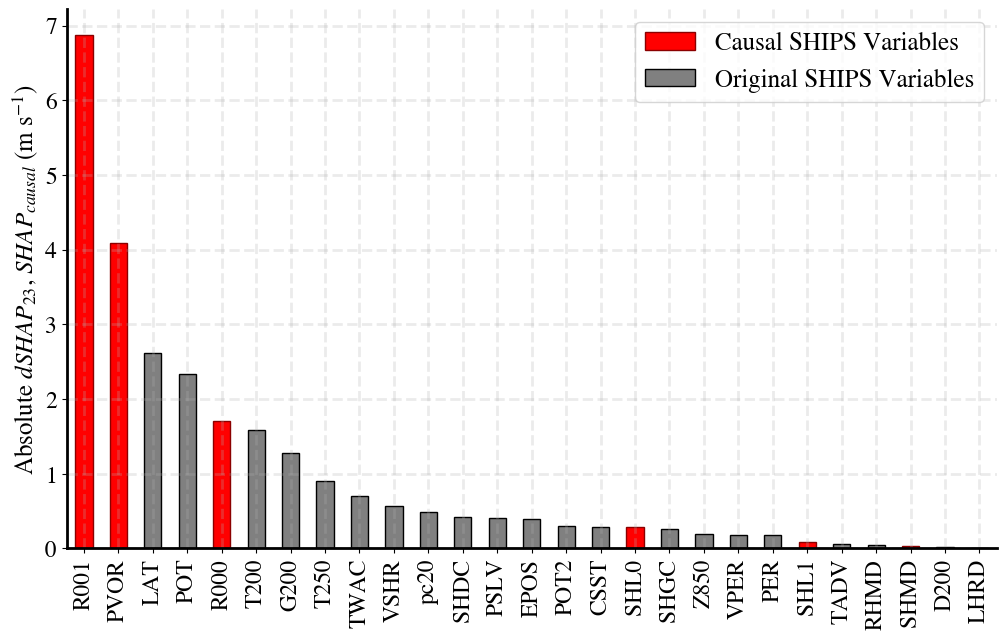

In [42]:
fig,ax = plt.subplots(1,1,figsize=(12,7))

highlight_var = ['SHL0','R000','SHMD','R001','SHL1','PVOR']
bar_colors = ['red' if var in highlight_var else 'gray' for var in shipsplus_abs_shap_larry_sorted.index]
bar_edges = ['darkred' if var in highlight_var else 'black' for var in shipsplus_abs_shap_larry_sorted.index]
shipsplus_abs_shap_larry_sorted['values'].plot.bar(ax=ax,color=bar_colors,edgecolor=bar_edges)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red',edgecolor='darkred',label='Causal SHIPS Variables'),
    Patch(facecolor='gray',edgecolor='black',label='Original SHIPS Variables')
]
ax.legend(handles=legend_elements,loc=1,fontsize=18)

plt.grid(alpha=0.25,lw=2,ls='--')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Absolute $dSHAP_{23}$, $SHAP_{causal}$ (m s$^{-1}$)',fontsize=18)
ax.set_xlabel("")
#plt.title('Larry (2023)',fontsize=17)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
plt.savefig('./figures/case_study_shap.png',dpi=600)
plt.show()

## Script for the MLPs and SHAP calculation

In [ ]:
# %% Define simple MLP model with 4 hidden layers, ReLU activation in hidden layers, and tanh activation in output layer
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
 
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    
shipsplus_mlp = '/work/FAC/FGSE/IDYST/tbeucler/default/milton/causal_pkls/mlp_models_causal_plus_4.pkl'
shipsold_mlp = '/work/FAC/FGSE/IDYST/tbeucler/default/milton/causal_pkls/mlp_models_causal_old_4.pkl'

with open(shipsold_mlp, 'rb') as f:
    oldships_mlp = pickle.load(f)

with open(shipsplus_mlp, 'rb') as f:
    plusships_mlp = pickle.load(f)

ships_plus_mlp = []
for izlc in range(7):
    model = MLP(27,512,1) # we do not specify ``weights``, i.e. create untrained model
    model.load_state_dict(plusships_mlp[f'results_fold_{izlc}.pkl']['model_state'])
    model.eval()
    ships_plus_mlp.append(np.squeeze(model(torch.FloatTensor(score_nocausal_plus[izlc]['X']['test']))).detach().numpy())
    plt.plot(np.squeeze(model(torch.FloatTensor(score_nocausal_plus[izlc]['X']['test'])).detach().numpy()),lw=0.25,alpha=0.5,color='r')
plt.plot(np.mean(np.asarray(ships_plus_mlp),axis=0),lw=2,color='r',label='MLP_SHIPS+')

ships_old_mlp = []
for izlc in range(7):
    model_old = MLP(21,512,1)
    model_old.load_state_dict(oldships_mlp[f'results_fold_{izlc}.pkl']['model_state'])
    model_old.eval()
    ships_old_mlp.append(np.squeeze(model_old(torch.FloatTensor(score_nocausal_old[izlc]['X']['test'])).detach().numpy()))
    plt.plot(np.squeeze(model_old(torch.FloatTensor(score_nocausal_old[izlc]['X']['test'])).detach().numpy()),lw=0.25,alpha=0.5,color='b')

In [ ]:
import shap
# %% Make a function that takes a numpy array, turns it into a torch tensor, and returns the model output
def get_ships_output(ships_model, data, device):
    """
    Get the model output for a given data input.

    Args:
        model: The trained PyTorch model.
        data: A numpy array of shape (n_samples, n_features).

    Returns:
        A numpy array of model predictions.
    """
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
        output = ships_model(data_tensor)
        return output.cpu().numpy()
        
def train_and_get_SHAP_explanations_SHIPS(Xtrain=None,trained_MLP_loc=None,izlc=3,MLPsettings=[21,512,1],background_size=500,seed=42,samples_to_explain=None):
    # %%
    ships_model = MLP(MLPsettings[0],MLPsettings[1],MLPsettings[2])
    ships_model.load_state_dict(trained_MLP_loc['model_state'])
    ships_model.eval()
    
    device='cpu'
    # %%
    background_ships = shap.sample(Xtrain, background_size)

    # %%
    predict_fn = lambda data: get_ships_output(ships_model, data, device)

    # Make a kernel explainer for each model
    explainer_ships = shap.KernelExplainer(
        predict_fn,  # model
        background_ships,  # Use a subset for memory efficiency
    )
    # Get the SHAP explanation
    explanation = explainer_ships(samples_to_explain)
    return explanation
#------------------------------------------------------------------------------------------------------------
# Obtain the SHIPS SHAP values for the Hurricane Larry samples
#------------------------------------------------------------------------------------------------------------
izlc=3
explanation = train_and_get_SHAP_explanations_SHIPS(Xtrain=score_nocausal_old[izlc]['X']['train'],\
                                                    trained_MLP_loc=oldships_mlp[f'results_fold_{izlc}.pkl'],\
                                                    izlc=izlc,\
                                                    MLPsettings=[21,512,1],\
                                                    background_size=500,\
                                                    seed=42,\
                                                    samples_to_explain=score_nocausal_old[izlc]['X']['test'][374:405]\
                                                   )

leadtime = 4
ships_shap_dict = {
    "explanation": explanation,       # numpy array
    "model": "ships",
    "leadtime": 4,
}

# Save
shap_dir = "./shap_results/"
os.makedirs(shap_dir, exist_ok=True)
plus_shap_path = os.path.join(shap_dir, f"ships_shap_values_{leadtime}_larry.pkl")

with open(plus_shap_path, "wb") as f:
    pickle.dump(ships_shap_dict, f)
#------------------------------------------------------------------------------------------------------------
# Obtain the SHIPS SHAP+ values for the Hurricane Larry samples
#------------------------------------------------------------------------------------------------------------
izlc=3
explanation_plus = train_and_get_SHAP_explanations_SHIPS(Xtrain=score_nocausal_plus[izlc]['X']['train'],\
                                                    trained_MLP_loc=plusships_mlp[f'results_fold_{izlc}.pkl'],\
                                                    izlc=izlc,\
                                                    MLPsettings=[27,512,1],\
                                                    background_size=500,\
                                                    seed=42,\
                                                    samples_to_explain=score_nocausal_plus[izlc]['X']['test'][374:405]\
                                                   )
leadtime = 4
plus_shap_dict = {
    "explanation": explanation_plus,       # numpy array
    "model": "plus",
    "leadtime": 4,
}

# Save
shap_dir = "./shap_results/"
os.makedirs(shap_dir, exist_ok=True)
plus_shap_path = os.path.join(shap_dir, f"plus_shap_values_{leadtime}_larry.pkl")

with open(plus_shap_path, "wb") as f:
    pickle.dump(plus_shap_dict, f)
#------------------------------------------------------------------------------------------------------------
# Obtain the SHIPS SHAP values for the last 300 test samples
#------------------------------------------------------------------------------------------------------------
izlc=3
explanation_ships_overall = train_and_get_SHAP_explanations_SHIPS(Xtrain=score_nocausal_old[izlc]['X']['train'],\
                                                    trained_MLP_loc=oldships_mlp[f'results_fold_{izlc}.pkl'],\
                                                    izlc=izlc,\
                                                    MLPsettings=[21,512,1],\
                                                    background_size=500,\
                                                    seed=42,\
                                                    samples_to_explain=score_nocausal_old[izlc]['X']['test'][-300:]\
                                                   )
leadtime = 4
ships_shap_dict_overall = {
    "explanation": explanation_ships_overall,       # numpy array
    "model": "ships",
    "leadtime": 4,
}

# Save
shap_dir = "./shap_results/"
os.makedirs(shap_dir, exist_ok=True)
ships_shap_path = os.path.join(shap_dir, f"ships_shap_values_{leadtime}_overall.pkl")

with open(ships_shap_path, "wb") as f:
    pickle.dump(ships_shap_dict_overall, f)
#------------------------------------------------------------------------------------------------------------
# Obtain the SHIPS+ SHAP values for the last 300 test samples
#------------------------------------------------------------------------------------------------------------
explanation_plus_overall = train_and_get_SHAP_explanations_SHIPS(Xtrain=score_nocausal_plus[izlc]['X']['train'],\
                                                    trained_MLP_loc=plusships_mlp[f'results_fold_{izlc}.pkl'],\
                                                    izlc=izlc,\
                                                    MLPsettings=[27,512,1],\
                                                    background_size=500,\
                                                    seed=42,\
                                                    samples_to_explain=score_nocausal_plus[izlc]['X']['test'][-300:]\
                                                   )
leadtime = 4
plus_shap_dict_overall = {
    "explanation": explanation_plus_overall,       # numpy array
    "model": "plus",
    "leadtime": 4,
}

# Save
shap_dir = "./shap_results/"
os.makedirs(shap_dir, exist_ok=True)
plus_shap_path = os.path.join(shap_dir, f"plus_shap_values_{leadtime}_overall.pkl")

with open(plus_shap_path, "wb") as f:
    pickle.dump(plus_shap_dict_overall, f)